## Parament

In [382]:
%matplotlib inline
import os
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

patch_size=7
num_classes = 3
layer=28 #要分割第几层

test_path = 'datasets/testdata'
train_path = 'datasets/traindata'

patch_shape=(3,9,9)
r=int(patch_shape[0]/2) #用到几层图像
extraction_step=(3,3,3)

## Utils

In [304]:
def get_mask(GT, values, label):
        if type(values) == int:
            values = [values]
        mask = np.zeros(GT.shape)
        for i in range(len(values)):
            mask += (GT == values[i]) * label
        return mask
    
def read_vol(path,n):
    path=os.path.join(path,n)
    itk_img=sitk.ReadImage(path)
    data=sitk.GetArrayFromImage(itk_img)
    return data

In [383]:
from sklearn.feature_extraction.image import extract_patches as sk_extract_patches
def extract_patches(volume, patch_shape, extraction_step) :
    patches = sk_extract_patches(
        volume,
        patch_shape=patch_shape,
        extraction_step=extraction_step) 
    #patches.shape(3,54,54,27,27) 3:1+(50-27)/9,54:1+(512-27)/9
    ndim = len(volume.shape) #dim=3
    npatches = np.prod(patches.shape[:ndim]) #multiply each number
    return patches.reshape((npatches, ) + patch_shape)

def build_set(T2_vols, label_vols, patch_shape, extraction_step=(9, 9, 9)) :
    patch_radius=int(patch_size/2)
    r1=int(patch_shape[0]/2)
    r2=int(patch_shape[1]/2)
    r3=int(patch_shape[2]/2)
    label_selector = [slice(None)] + [slice(r1,r1+1)]+[slice(r2, r2+1)]+[slice(r3,r3+1)]
    x = np.zeros((0, patch_shape[0],patch_shape[1],patch_shape[2]))
    y = np.zeros((0, 1))
    for idx in range(len(T2_vols)) : #6
        y_length = len(y) #0

        label_patches = extract_patches(label_vols[idx], patch_shape, extraction_step)#（8748，7,7,7）
        totalpatch = label_patches[label_selector] #(8748,1,1,1)

        valid_idxs = np.where(totalpatch[:,0,0,0]!= 0) 
        label_patches = totalpatch[valid_idxs] #(2614,1,1,1)

        x = np.vstack((x, np.zeros((len(label_patches),patch_shape[0],patch_shape[1],patch_shape[2]))))
        y = np.vstack((y, np.zeros((len(label_patches),1))))

        for i in range(len(label_patches)) :
            y[i+y_length, :]=label_patches[i,0,0,0]
            #y[i+y_length, :, :] = np_utils.to_categorical(label_patches[i, : ,: ,:]-1, num_classes)
        del label_patches
        
        # Sampling strategy: reject samples which labels are only zeros
        T2_train = extract_patches(T2_vols[idx], patch_shape, extraction_step)
        x[y_length:,:, :, :] = T2_train[valid_idxs]
        del T2_train
        
    return x, y,valid_idxs,totalpatch

In [232]:
def dice(gt,testlabel): #(2341,1)
    a=np.sum(gt[:,0]==1)
    b=np.sum(testlabel[:,0]==1)
    m1g=np.where(gt[:,0]==1,1,0)
    m1l=np.where(testlabel[:,0]==1,1,0)
    m1=m1g+m1l
    c1=np.sum(m1==2)
    dice_gm=c1*2/(a+b)
    
    a=np.sum(gt[:,0]==2)
    b=np.sum(testlabel[:,0]==2)
    m2g=np.where(gt[:,0]==2,1,0)
    m2l=np.where(testlabel[:,0]==2,1,0)
    m2=m2g+m2l
    c2=np.sum(m2==2)
    dice_wm=c2*2/(a+b)
    
    a=np.sum(gt[:,0]==3)
    b=np.sum(testlabel[:,0]==3)
    m3g=np.where(gt[:,0]==3,1,0)
    m3l=np.where(testlabel[:,0]==3,1,0)
    m3=m3g+m3l
    c3=np.sum(m3==2)
    dice_csf=c3*2/(a+b)
    return dice_gm,dice_wm,dice_csf

## 1.1 Read data &Processing data

### (1) Train data

In [384]:
T2_vols = np.empty((6, 50, 512, 512))
label_vols = np.empty((6, 50, 512, 512))
name=os.listdir(train_path)
idx=0
for n in name:
    picname=n.split('.')[0]
    if(picname.split('_')[-1]=='seg'):
        continue  
    segname=picname.split('_')[0]+'_seg.mha'
    label_vols[idx]=read_vol(train_path,segname)
    T2_vols[idx] = read_vol(train_path,n)
    idx+=1

## deal with label
CSF_mask = get_mask(label_vols, values=[5,6], label=3)
GM_mask = get_mask(label_vols, values=[1,7,8], label=1)
WM_mask = get_mask(label_vols, values=[2], label=2)
label_vols = CSF_mask + GM_mask + WM_mask  

## Intensity normalisation (zero mean and unit variance)
T2_mean = T2_vols.mean()
T2_std = T2_vols.std()
T2_vols = (T2_vols - T2_mean) / T2_std

In [385]:
forever_T2=T2_vols
forever_Label=label_vols

In [386]:
label_vols=label_vols[:,layer-r:layer+r+1]
T2_vols=T2_vols[:,layer-r:layer+r+1]

### (2) Test data

In [387]:
T2_test = np.empty((1, 50, 512, 512))
ground_true = np.empty((1, 50, 512, 512))
name=os.listdir(test_path)
picname=name[0].split('_')[0]

gtname=picname+'_seg.mha'
testname=picname+'_t2.mha'

ground_true[0]=read_vol(test_path,gtname)
T2_test[0] = read_vol(test_path,testname)

CSF_mask = get_mask(ground_true, values=[5,6], label=3)
GM_mask = get_mask(ground_true, values=[1,7,8], label=1)
WM_mask = get_mask(ground_true, values=[2], label=2)
ground_true = CSF_mask + GM_mask + WM_mask 

## Intensity normalisation (zero mean and unit variance)
T2_mean = T2_test.mean()
T2_std = T2_test.std()
T2_test = (T2_test - T2_mean) / T2_std

In [388]:
ground_true=ground_true[:,layer-r:layer+r+1]
T2_test=T2_test[:,layer-r:layer+r+1]

In [389]:
print(label_vols.shape)
print(T2_test.shape)

(6, 3, 512, 512)
(1, 3, 512, 512)


## 1.2 Make Train dataset

In [390]:
x_train,y_train,idx,repatch=build_set(T2_vols,label_vols,patch_shape,extraction_step)

In [391]:
y_train.shape

(39634, 1)

In [392]:
print('GM:',np.sum(y_train[:,0]==1))
print('WM:',np.sum(y_train[:,0]==2))
print('CSF:',np.sum(y_train[:,0]==3))

GM: 13998
WM: 17935
CSF: 7701


In [393]:
x_train=x_train.reshape((x_train.shape[0],np.prod(patch_shape)))

In [394]:
print(x_train.shape,y_train.shape)

(39634, 243) (39634, 1)


## 1.3 Training

In [399]:
from sklearn.ensemble import RandomForestClassifier 
rf0 = RandomForestClassifier(n_estimators=20,oob_score=True)  
# rf0 = RandomForestClassifier(n_estimators=20，max_depth=18，min_samples_leaf=7)  
rf0.fit(x_train,y_train)  
#print(rf0.oob_score_)

/Users/zhangweiting/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/Users/zhangweiting/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/zhangweiting/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:456: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [396]:
rf0.n_features_

243

In [400]:
rf0.oob_score_

0.85603269919765856

## 2.1 Make Test dataset

In [401]:
x_test,ground_true,index,fullpatch=build_set(T2_test,ground_true,patch_shape,(3,1,1))

In [402]:
x_test=x_test.reshape((x_test.shape[0],np.prod(patch_shape)))

## 2.2 Testing

In [418]:
gm=np.sum(ground_true[:,0]==1)
wm=np.sum(ground_true[:,0]==2)
csf=np.sum(ground_true[:,0]==3)
print('GM:',gm)
print('WM:',wm)
print('CSF:',csf)
print("")
gm=np.sum(test_res[:,0]==1)
wm=np.sum(test_res[:,0]==2)
csf=np.sum(test_res[:,0]==3)
print('GM:',gm)
print('WM:',wm)
print('CSF:',csf)

GM: 17727
WM: 32078
CSF: 10726

GM: 25118
WM: 25867
CSF: 9546


In [404]:
test_res=rf0.predict(x_test) #need to reshape
test_res=test_res.reshape(test_res.shape[0],1)

## 2.3 Dice

In [417]:
dice_gm,dice_wm,dice_csf=dice(ground_true,test_res)
print(dice_gm,dice_wm,dice_csf)

0.787536468666 0.854499956856 0.891179952644


## 3.1 Plot Image and ProbImg

In [421]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
import math
height=int(math.sqrt(fullpatch.shape[0]))

In [427]:
c=rf0.predict_proba(x_test)
c.shape

(60531, 3)

## 3.2 Reconstruct Image

### (1) Ground True Image

In [367]:
fp=np.zeros((fullpatch.shape[0],1,1))
fp[:,0,0]=fullpatch[:,0,0,0]
GT=reconstruct_from_patches_2d(fp,(height,height)) 

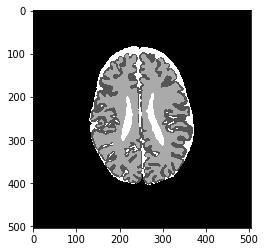

In [368]:
# plt.savefig("GT28.jpg")
plt.imshow(GT,cmap='gray')

### (2) Result

In [369]:
test=np.zeros((fullpatch.shape[0],1,1))
test[:,0,0]=fullpatch[:,0,0,0]
test[index,0,0]=test_res[:,0]
test28=reconstruct_from_patches_2d(test,(height,height)) 

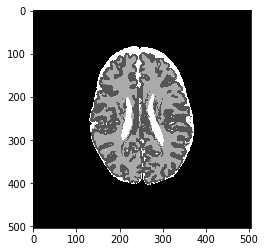

In [419]:
plt.imshow(test28,cmap='gray')
# plt.savefig("test28.jpg")

### (3)GM Prob

In [423]:
gm=c[:,0]
gm=gm.reshape((len(gm),1))
probgm=np.zeros((fullpatch.shape[0],1,1))
probgm[:,0,0]=fullpatch[:,0,0,0]
probgm[index,0,0]=gm[:,0]
gm=reconstruct_from_patches_2d(probgm,(height,height)) 

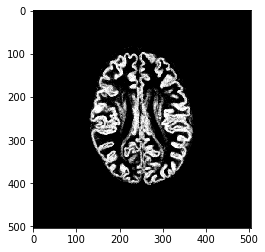

In [424]:
plt.imshow(gm,cmap='gray')

### (4) WM Prob

In [433]:
wm=c[:,1]
wm=wm.reshape((len(wm),1))
probwm=np.zeros((fullpatch.shape[0],1,1))
probwm[:,0,0]=fullpatch[:,0,0,0]
probwm[index,0,0]=wm[:,0]
wm=reconstruct_from_patches_2d(probwm,(height,height)) 

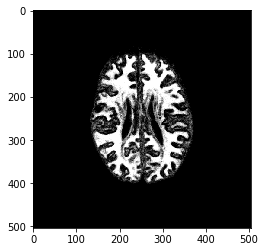

In [437]:
plt.imshow(wm,cmap='gray')

### (5) CSF Prob

In [439]:
csf=c[:,2]
csf=csf.reshape((len(csf),1))
probcsf=np.zeros((fullpatch.shape[0],1,1))
probcsf[:,0,0]=fullpatch[:,0,0,0]
probcsf[index,0,0]=csf[:,0]
csf=reconstruct_from_patches_2d(probcsf,(height,height)) 

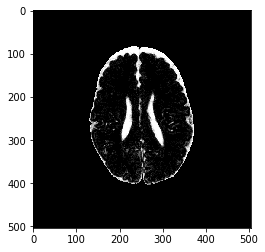

In [440]:
plt.imshow(csf,cmap='gray')